In [ ]:
!pip install scikit-learn==1.5.2
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [5]:
!pip install --upgrade numpy
!pip install --upgrade --force-reinstall scikit-learn==1.5.2 catboost ipywidgets pandas
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import pickle
from sklearn.model_selection import cross_val_score
import os
import scipy.stats as stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Specify the path to your Excel file
file_path = '/content/drive/MyDrive/GHIGC/Datasets/Pooled molecules sectioned.XLSX'

data = pd.read_csv("/Users/lokeshkumar/Drug_Discovery/augmented_GLP_GCGR_GLP1R_unique_logEC50.csv")
#data = pd.read_csv("/Users/lokeshkumar/Drug_Discovery/augmented_GLP_GCGR_GLP1R_unique_logEC50.csv")


In [ ]:
print(data.head())
data.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)

print(data.head())


  molecule_chembl_id                                   canonical_smiles  pEC50
0      CHEMBL4128112  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...    0.0
1      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
2      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
3      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
4      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
  molecule_chembl_id                                             SMILES  pEC50
0      CHEMBL4128112  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...    0.0
1      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
2      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
3      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0
4      CHEMBL4128112  CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...    0.0


In [ ]:
from tqdm import tqdm
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

# Function to convert SMILES to molecular fingerprint
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = generator.GetFingerprint(mol)
        return np.array(fp)
    else:
        return np.zeros(n_bits)

# Apply with tqdm progress bar
fingerprints = []
for smiles in tqdm(data['SMILES'], desc="Generating Fingerprints", unit="mol"):
    fingerprints.append(smiles_to_fingerprint(smiles))

# Assign back to DataFrame
data['Fingerprint'] = fingerprints


Generating Fingerprints: 100%|████████████| 6826/6826 [00:16<00:00, 412.95mol/s]


In [ ]:
data

,molecule_chembl_id,SMILES,pEC50,Fingerprint,Descriptors
0,CHEMBL4128112,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.357615736005359, 15.357615736005359, 0.006..."
1,CHEMBL4128112,CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.362245365634989, 15.362245365634989, 0.007..."
2,CHEMBL4128112,CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.365846188680257, 15.365846188680257, 0.007..."
3,CHEMBL4128112,CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.35843185170784, 15.35843185170784, 0.00702..."
4,CHEMBL4128112,CC[C@H](C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)N...,0.000000,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.359673349174084, 15.359673349174084, 0.007..."
...,...,...,...,...,...
6821,CHEMBL5400455,C(=O)(N[C@@H](C)C(N1CCC[C@H]1C(N1CCC[C@H]1C(=O...,0.721246,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.552971405864094, 15.552971405864094, 0.004..."
6822,CHEMBL5400455,C(N[C@H](C(=O)N[C@H](C(N[C@H](C(=O)N[C@@H](CC(...,0.721246,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.552971405864097, 15.552971405864097, 0.004..."
6823,CHEMBL5431072,NC(CC[C@@H](C(=O)NCC(N[C@H](C(=O)N[C@H](C(N[C@...,0.376751,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.542818870916083, 15.542818870916083, 0.005..."
6824,CHEMBL5431072,[C@@H](C)([C@H](NC(=O)CNC([C@H](CCC(=O)N)NC([C...,0.376751,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[15.54281887091608, 15.54281887091608, 0.00565..."


In [ ]:
# Function to calculate RDKit descriptors with error handling
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array([desc[1](mol) for desc in Descriptors.descList])
    else:
        return np.zeros(len(Descriptors.descList))

# Convert descriptors using tqdm for progress tracking
descriptors_list = []
for smiles in tqdm(data['SMILES'], desc="Calculating Descriptors", unit="mol"):
    descriptors_list.append(calculate_descriptors(smiles))

# Convert list to NumPy array and assign to DataFrame
data['Descriptors'] = descriptors_list

Calculating Descriptors: 100%|███████████| 6826/6826 [1:26:12<00:00,  1.32mol/s]


In [ ]:
fingerprints = np.array(data['Fingerprint'].tolist())
descriptors = np.array(data['Descriptors'].tolist())
X = np.concatenate([fingerprints, descriptors], axis=1)
y = data['pEC50'].values

In [ ]:
fingerprints.shape


(6826, 2048)

In [ ]:
descriptors.shape


(6826, 217)

In [ ]:
X.shape

(6826, 2265)

In [ ]:
print("Max value in X:", np.max(X))
print("Min value in X:", np.min(X))

# Check for features with extremely large ranges
feature_max = np.max(X, axis=0)
feature_min = np.min(X, axis=0)
feature_ranges = feature_max - feature_min

print("Max feature range:", np.max(feature_ranges))
print("Min feature range:", np.min(feature_ranges))

# Check if any value is larger than a safe threshold (e.g., 1e6)
print("Number of features with max value > 1e6:", np.sum(feature_max > 1e6))


Max value in X: 1.361644977839016e+176
Min value in X: -85.13493734911036
Max feature range: 1.361644977839016e+176
Min feature range: 0.0
Number of features with max value > 1e6: 1


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Apply log transformation if necessary
X_transformed = np.log1p(np.abs(X_imputed))



# Normalize & Standardize
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler_minmax.fit_transform(X_transformed)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_normalized)

print(f"Final dataset shape: {X_scaled.shape}")


Final dataset shape: (6826, 2265)


In [ ]:
print("Max value in X:", np.max(X_scaled))
print("Min value in X:", np.min(X_scaled))

# Check for features with extremely large ranges
feature_max = np.max(X_scaled, axis=0)
feature_min = np.min(X_scaled, axis=0)
feature_ranges = feature_max - feature_min

print("Max feature range:", np.max(feature_ranges))
print("Min feature range:", np.min(feature_ranges))

# Check if any value is larger than a safe threshold (e.g., 1e6)
print("Number of features with max value > 1e6:", np.sum(feature_max > 1e6))

Max value in X: 82.61355820928904
Min value in X: -41.29769969380938
Max feature range: 82.62566275994241
Min feature range: 0.0
Number of features with max value > 1e6: 0


In [ ]:
# Define feature names
fingerprint_features = [f'fingerprint_{i}' for i in range(fingerprints.shape[1])]
descriptor_features = [desc[0] for desc in Descriptors.descList]
feature_names = fingerprint_features + descriptor_features


In [ ]:
print(f"Updated number of feature names: {len(feature_names)}")
print(f"Updated number of columns in X: {X_scaled.shape[1]}")

Updated number of feature names: 2265
Updated number of columns in X: 2265


In [ ]:
# Ensure the length of feature_names matches the number of columns in X
assert len(feature_names) == X_scaled.shape[1], "Length of feature_names must match number of columns in X"

In [ ]:
print("Number of feature names:", len(feature_names))
print("Number of columns in X:", X.shape[1])


Number of feature names: 2265
Number of columns in X: 2265


In [ ]:
import numpy as np

print("Number of NaN values in X:", np.isnan(X_scaled).sum())
print("Number of Infinite values in X:", np.isinf(X_scaled).sum())


Number of NaN values in X: 0
Number of Infinite values in X: 0


In [ ]:
from tqdm import tqdm
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

# Initialize Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Define a range of features to evaluate
feature_range = list(range(50, 1001, 50)) + list(range(1000, 2001, 200)) + [2258]

scores = []

# Perform RFE for each number of features in the range
for n_features in tqdm(feature_range, desc="Feature Selection Progress", unit="step"):
    # Create a pipeline with RFE and RandomForestRegressor
    pipeline = Pipeline([
        ('feature_selection', RFE(estimator=rf, n_features_to_select=n_features, step=50)),
        ('regressor', rf)
    ])

    # Perform cross-validation with the pipeline
    score = cross_val_score(pipeline, X_scaled, y, cv=5, scoring='r2', n_jobs=-1).mean()
    scores.append(score)

# Convert scores to a numpy array
scores = np.array(scores)


Feature Selection Progress: 100%|██████████| 27/27 [5:13:17<00:00, 696.19s/step]


In [ ]:
scores

array([-0.5738382 , -0.57751569, -0.59535605, -0.58139971, -0.60270726,
       -0.60434606, -0.59225006, -0.57882623, -0.5937718 , -0.5846071 ,
       -0.60366594, -0.59832215, -0.59177775, -0.58451756, -0.5974552 ,
       -0.60235548, -0.5861065 , -0.58561161, -0.57289711, -0.58428951,
       -0.58428951, -0.59473231, -0.60993715, -0.5986568 , -0.58888536,
       -0.6033275 , -0.58524583])

In [ ]:
optimal_features

950

In [ ]:
np.save('scores.npy', scores)

In [ ]:
print(scores.size)

27


In [ ]:
!pwd
!ls -lrth|grep .npy

/Users/lokeshkumar/Drug_Discovery
-rw-r--r--  1 lokeshkumar  staff   344B Mar 13 17:57 scores.npy


In [ ]:
# Find the optimal number of features
optimal_features = feature_range[np.argmax(scores)]
print(f'Optimal number of features: {optimal_features}')


Optimal number of features: 950


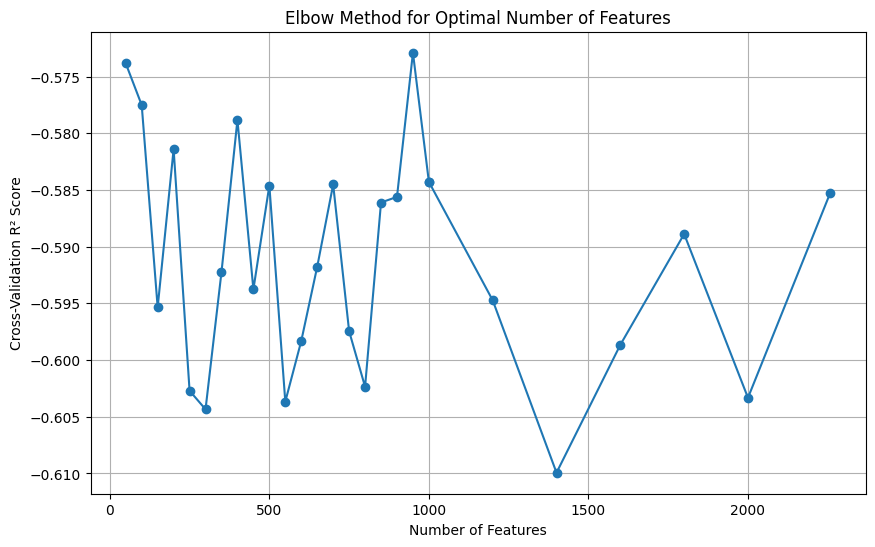

Optimal number of features: 950


In [ ]:
# Plot the scores to find the optimal number of features
plt.figure(figsize=(10, 6))
plt.plot(feature_range, scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation R² Score')
plt.title('Elbow Method for Optimal Number of Features')
plt.grid(True)
plt.show()

# Find the optimal number of features
optimal_features = feature_range[np.argmax(scores)]
print(f'Optimal number of features: {optimal_features}')

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
selector = RFE(estimator=rf, n_features_to_select=optimal_features, step=50, verbose=1)
selector = selector.fit(X_scaled, y)


Fitting estimator with 2265 features.
Fitting estimator with 2215 features.
Fitting estimator with 2165 features.
Fitting estimator with 2115 features.
Fitting estimator with 2065 features.
Fitting estimator with 2015 features.
Fitting estimator with 1965 features.
Fitting estimator with 1915 features.
Fitting estimator with 1865 features.
Fitting estimator with 1815 features.
Fitting estimator with 1765 features.
Fitting estimator with 1715 features.
Fitting estimator with 1665 features.
Fitting estimator with 1615 features.
Fitting estimator with 1565 features.
Fitting estimator with 1515 features.
Fitting estimator with 1465 features.
Fitting estimator with 1415 features.
Fitting estimator with 1365 features.
Fitting estimator with 1315 features.
Fitting estimator with 1265 features.
Fitting estimator with 1215 features.
Fitting estimator with 1165 features.
Fitting estimator with 1115 features.
Fitting estimator with 1065 features.
Fitting estimator with 1015 features.
Fitting esti

In [ ]:
X_selected = selector.transform(X_scaled)
print(f'Shape of the new feature set: {X_selected.shape}')

Shape of the new feature set: (6826, 950)


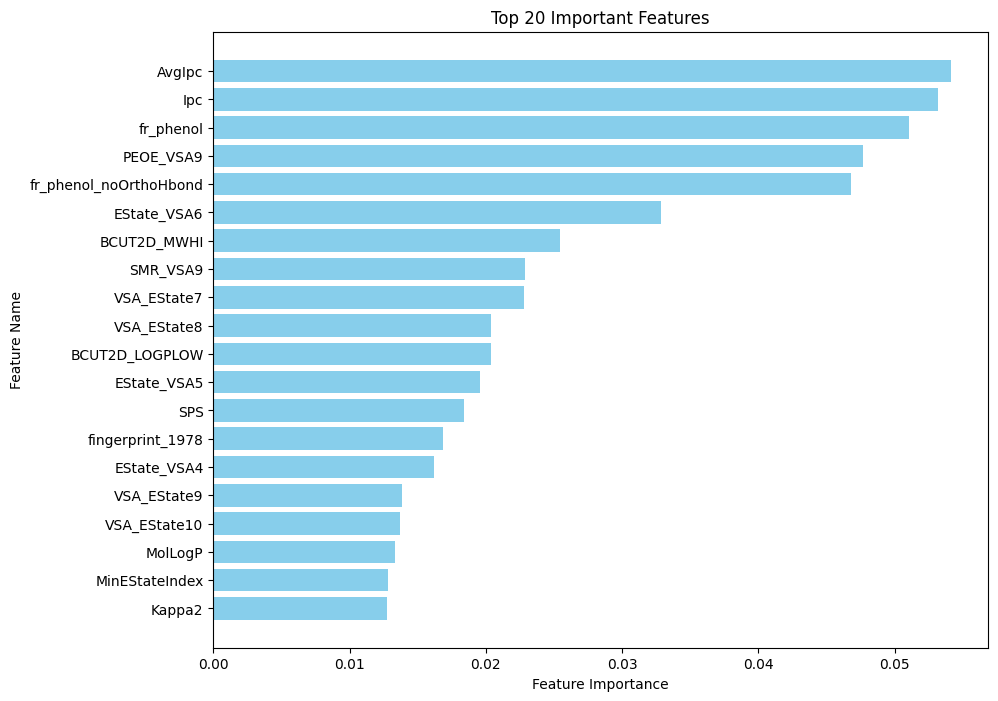

In [ ]:
# Get the ranking of the features from the RFE selector
ranking = selector.ranking_

# Identify the important features (those with a ranking of 1)
important_indices = np.where(ranking == 1)[0]
important_features = [feature_names[i] for i in important_indices]

# Get the feature importances from the RandomForest model
importances = selector.estimator_.feature_importances_

# Sort the features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [important_features[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

# Plot the top N important features
N = 20  # Number of top features to display
plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:N], sorted_importances[:N], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title(f'Top {N} Important Features')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:
X_train.shape


(5460, 950)

In [ ]:
X_test.shape


(1366, 950)

In [ ]:
# Hyperparameter grids for base models
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_svr = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

param_grid_catboost = {
    'depth': [6, 8],
    'learning_rate': [0.1, 0.01],
    'iterations': [100, 200]
}


In [ ]:
# GridSearch for hyperparameter tuning
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, n_jobs=-1, verbose=1)
grid_search_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, n_jobs=-1, verbose=1)
grid_search_catboost = GridSearchCV(CatBoostRegressor(random_state=42, silent=True), param_grid_catboost, cv=5, n_jobs=-1, verbose=1)

grid_search_rf.fit(X_train, y_train)
grid_search_svr.fit(X_train, y_train)
grid_search_catboost.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
best_svr = grid_search_svr.best_estimator_
best_catboost = grid_search_catboost.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [ ]:
# EVALUATEABOVE ESTIMATORS
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

for model in [best_rf, best_svr, best_catboost]:
    model_name = type(model).__name__
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_rmse = root_mean_squared_error(y_pred=train_preds, y_true=y_train)
    train_mae =  root_mean_squared_error(y_pred=train_preds, y_true=y_train)
    test_rmse = root_mean_squared_error(y_pred=test_preds, y_true=y_test)
    test_mae =  root_mean_squared_error(y_pred=test_preds, y_true=y_test)

    print(f"---------------------- {model_name} ----------------------")
    print(f"Train: RMSE {train_rmse}, MAE: {train_mae}")
    print(f"Test: RMSE {test_rmse}, MAE: {test_mae}")
    print("-----------------------------------------------------------")

---------------------- RandomForestRegressor ----------------------
Train: RMSE 0.14439533260331727, MAE: 0.14439533260331727
Test: RMSE 0.27867628988759746, MAE: 0.27867628988759746
-----------------------------------------------------------
---------------------- SVR ----------------------
Train: RMSE 0.3463530096517262, MAE: 0.3463530096517262
Test: RMSE 0.45019393324933193, MAE: 0.45019393324933193
-----------------------------------------------------------
---------------------- CatBoostRegressor ----------------------
Train: RMSE 0.2513530165257211, MAE: 0.2513530165257211
Test: RMSE 0.3214419505909667, MAE: 0.3214419505909667
-----------------------------------------------------------


In [ ]:
np.median(y_train)

1.214670164989233

In [ ]:
X_train.shape

(5460, 950)

In [ ]:
# Chemception model definition
def create_chemception_model(input_shape, filters=32, kernel_size=3, pool_size=2, dense_units=100, learning_rate=0.001, **kwargs):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(input_shape[1],1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [ ]:
x_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
keras_model = create_chemception_model(input_shape=x_reshaped.shape)

In [ ]:
keras_model.fit(x=x_reshaped, y=y_train, epochs=150)

Epoch 1/150
171/171 [==============================] - 1s 3ms/step - loss: 0.3953
Epoch 2/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2954
Epoch 3/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2767
Epoch 4/150
171/171 [==============================] - 1s 4ms/step - loss: 0.2619
Epoch 5/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2569
Epoch 6/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2482
Epoch 7/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2446
Epoch 8/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2387
Epoch 9/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2355
Epoch 10/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2335
Epoch 11/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2309
Epoch 12/150
171/171 [==============================] - 1s 3ms/step - loss: 0.2294
Epoch 13/150


In [ ]:
X_test_reshape = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
test_predictions = keras_model.predict(X_test_reshape).flatten()
train_predictions = keras_model.predict(x_reshaped).flatten()

train_rmse = root_mean_squared_error(y_pred=train_predictions, y_true=y_train)
train_mae =  root_mean_squared_error(y_pred=train_predictions, y_true=y_train)
test_rmse = root_mean_squared_error(y_pred=test_predictions, y_true=y_test)
test_mae =  root_mean_squared_error(y_pred=test_predictions, y_true=y_test)

print(f"---------------------- Keras Baseline Model ----------------------")
print(f"Train: RMSE {train_rmse}, MAE: {train_mae}")
print(f"Test: RMSE {test_rmse}, MAE: {test_mae}")
print("-----------------------------------------------------------")

171/171 [==============================] - 0s 1ms/step
---------------------- Keras Baseline Model ----------------------
Train: RMSE 0.41438122069541367, MAE: 0.41438122069541367
Test: RMSE 0.4959824548381303, MAE: 0.4959824548381303
-----------------------------------------------------------


In [ ]:
import optuna

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):

    """Objective function for Optuna optimization."""

    filters = trial.suggest_categorical('filters', [16, 32, 64, 128])
    kernel_size = trial.suggest_int('kernel_size', 3, 7)
    pool_size = trial.suggest_int('pool_size', 2, 4)
    dense_units = trial.suggest_int('dense_units', 50, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
     # filters=32, kernel_size=3, pool_size=2, dense_units=100, learning_rate=0.001
    model = create_chemception_model(
        input_shape=x_reshaped.shape,
        filters=filters,
        kernel_size=kernel_size,
        pool_size=pool_size,
        dense_units=dense_units,
        learning_rate=learning_rate
    )

    history = model.fit(x_reshaped, y_train,
        epochs=150,
        batch_size=batch_size,
        verbose=0
    )
    test_predictions = model.predict(X_test_reshape).flatten()
    return root_mean_squared_error(y_pred=test_predictions, y_true=y_test)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-03-13 22:06:36,965] A new study created in memory with name: no-name-9c4af843-7577-47bc-aade-3f6cadb59ec1
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:07:42,877] Trial 0 finished with value: 0.49394447815510084 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 3, 'dense_units': 88, 'learning_rate': 0.005434768598851052, 'batch_size': 32}. Best is trial 0 with value: 0.49394447815510084.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:10:04,556] Trial 1 finished with value: 0.5071969962820819 and parameters: {'filters': 16, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 160, 'learning_rate': 0.0005661163598892068, 'batch_size': 16}. Best is trial 0 with value: 0.49394447815510084.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 3ms/step


[I 2025-03-13 22:11:30,091] Trial 2 finished with value: 0.5659854805992374 and parameters: {'filters': 128, 'kernel_size': 5, 'pool_size': 4, 'dense_units': 177, 'learning_rate': 0.002708363994651583, 'batch_size': 64}. Best is trial 0 with value: 0.49394447815510084.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 1ms/step


[I 2025-03-13 22:12:07,129] Trial 3 finished with value: 0.49486813008993485 and parameters: {'filters': 16, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 185, 'learning_rate': 0.0021022806767893826, 'batch_size': 64}. Best is trial 0 with value: 0.49394447815510084.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:15:04,597] Trial 4 finished with value: 0.5357221180703629 and parameters: {'filters': 128, 'kernel_size': 3, 'pool_size': 4, 'dense_units': 105, 'learning_rate': 0.0001199267394630977, 'batch_size': 16}. Best is trial 0 with value: 0.49394447815510084.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:17:13,826] Trial 5 finished with value: 0.5123732099790667 and parameters: {'filters': 64, 'kernel_size': 7, 'pool_size': 4, 'dense_units': 56, 'learning_rate': 0.007181652094813528, 'batch_size': 16}. Best is trial 0 with value: 0.49394447815510084.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 1ms/step


[I 2025-03-13 22:19:19,882] Trial 6 finished with value: 0.4889713009853781 and parameters: {'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 103, 'learning_rate': 0.0014532481260858682, 'batch_size': 16}. Best is trial 6 with value: 0.4889713009853781.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:21:48,022] Trial 7 finished with value: 0.6472582161414211 and parameters: {'filters': 128, 'kernel_size': 7, 'pool_size': 3, 'dense_units': 148, 'learning_rate': 0.00013689612672490229, 'batch_size': 32}. Best is trial 6 with value: 0.4889713009853781.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:23:57,157] Trial 8 finished with value: 0.5326326141183101 and parameters: {'filters': 32, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 123, 'learning_rate': 0.009563553543776778, 'batch_size': 16}. Best is trial 6 with value: 0.4889713009853781.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:25:57,085] Trial 9 finished with value: 0.523949533980987 and parameters: {'filters': 16, 'kernel_size': 4, 'pool_size': 3, 'dense_units': 64, 'learning_rate': 0.000909744216585115, 'batch_size': 16}. Best is trial 6 with value: 0.4889713009853781.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:27:27,791] Trial 10 finished with value: 0.4903993370370337 and parameters: {'filters': 64, 'kernel_size': 4, 'pool_size': 2, 'dense_units': 88, 'learning_rate': 0.00046805461520127407, 'batch_size': 32}. Best is trial 6 with value: 0.4889713009853781.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:28:58,073] Trial 11 finished with value: 0.5115812026578416 and parameters: {'filters': 64, 'kernel_size': 4, 'pool_size': 2, 'dense_units': 92, 'learning_rate': 0.0005555382104203867, 'batch_size': 32}. Best is trial 6 with value: 0.4889713009853781.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:30:27,558] Trial 12 finished with value: 0.4866003105425058 and parameters: {'filters': 64, 'kernel_size': 4, 'pool_size': 2, 'dense_units': 118, 'learning_rate': 0.00028275379735670557, 'batch_size': 32}. Best is trial 12 with value: 0.4866003105425058.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:31:32,466] Trial 13 finished with value: 0.5005646419917592 and parameters: {'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 134, 'learning_rate': 0.000258154500815076, 'batch_size': 32}. Best is trial 12 with value: 0.4866003105425058.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:32:22,292] Trial 14 finished with value: 0.5102648083901038 and parameters: {'filters': 64, 'kernel_size': 4, 'pool_size': 3, 'dense_units': 117, 'learning_rate': 0.0018499920138427216, 'batch_size': 64}. Best is trial 12 with value: 0.4866003105425058.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:35:26,088] Trial 15 finished with value: 0.4820094231975249 and parameters: {'filters': 64, 'kernel_size': 5, 'pool_size': 2, 'dense_units': 141, 'learning_rate': 0.0002472761806046064, 'batch_size': 16}. Best is trial 15 with value: 0.4820094231975249.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:37:06,033] Trial 16 finished with value: 0.500633400575259 and parameters: {'filters': 64, 'kernel_size': 5, 'pool_size': 3, 'dense_units': 200, 'learning_rate': 0.00020789467670618902, 'batch_size': 32}. Best is trial 15 with value: 0.4820094231975249.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:38:51,741] Trial 17 finished with value: 0.4830152684233249 and parameters: {'filters': 64, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 144, 'learning_rate': 0.00020375613197661917, 'batch_size': 32}. Best is trial 15 with value: 0.4820094231975249.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 3ms/step


[I 2025-03-13 22:42:03,195] Trial 18 finished with value: 0.48583756877057555 and parameters: {'filters': 64, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 144, 'learning_rate': 0.00018876823212202136, 'batch_size': 16}. Best is trial 15 with value: 0.4820094231975249.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:43:00,397] Trial 19 finished with value: 0.5089611885441697 and parameters: {'filters': 64, 'kernel_size': 5, 'pool_size': 3, 'dense_units': 161, 'learning_rate': 0.00036332354950629174, 'batch_size': 64}. Best is trial 15 with value: 0.4820094231975249.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:45:16,724] Trial 20 finished with value: 0.4713187842083525 and parameters: {'filters': 32, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 154, 'learning_rate': 0.0009643991126971767, 'batch_size': 16}. Best is trial 20 with value: 0.4713187842083525.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:47:33,199] Trial 21 finished with value: 0.4988495782005872 and parameters: {'filters': 32, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 158, 'learning_rate': 0.0008827023195601287, 'batch_size': 16}. Best is trial 20 with value: 0.4713187842083525.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:49:48,354] Trial 22 finished with value: 0.49113610454511325 and parameters: {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'dense_units': 141, 'learning_rate': 0.00013653591021561292, 'batch_size': 16}. Best is trial 20 with value: 0.4713187842083525.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:52:07,358] Trial 23 finished with value: 0.539508368602802 and parameters: {'filters': 32, 'kernel_size': 6, 'pool_size': 2, 'dense_units': 175, 'learning_rate': 0.0011313921276164926, 'batch_size': 16}. Best is trial 20 with value: 0.4713187842083525.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:54:26,087] Trial 24 finished with value: 0.48626363158860164 and parameters: {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'dense_units': 154, 'learning_rate': 0.000664354430007763, 'batch_size': 16}. Best is trial 20 with value: 0.4713187842083525.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:55:54,322] Trial 25 finished with value: 0.497204709785679 and parameters: {'filters': 64, 'kernel_size': 6, 'pool_size': 3, 'dense_units': 133, 'learning_rate': 0.003389253171087928, 'batch_size': 32}. Best is trial 20 with value: 0.4713187842083525.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 22:59:01,956] Trial 26 finished with value: 0.4612862008648262 and parameters: {'filters': 64, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 171, 'learning_rate': 0.000330113698126389, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:01:19,793] Trial 27 finished with value: 0.46889785225619124 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 172, 'learning_rate': 0.00035028647160009947, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:03:31,492] Trial 28 finished with value: 0.48553890765289565 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 3, 'dense_units': 172, 'learning_rate': 0.00037884376377397225, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:05:41,930] Trial 29 finished with value: 0.4742934031289504 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 3, 'dense_units': 193, 'learning_rate': 0.0007455183334367278, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:07:59,688] Trial 30 finished with value: 0.46572895635594336 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 166, 'learning_rate': 0.0003847396741187907, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:10:16,321] Trial 31 finished with value: 0.4748528387855448 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 169, 'learning_rate': 0.0003734120950425689, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:12:32,040] Trial 32 finished with value: 0.4832909499744158 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 185, 'learning_rate': 0.00038669717949891375, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:14:49,532] Trial 33 finished with value: 0.4775907866079042 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 164, 'learning_rate': 0.0005289817718176089, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


43/43 [==============================] - 0s 2ms/step


[I 2025-03-13 23:17:05,270] Trial 34 finished with value: 0.48826321555657043 and parameters: {'filters': 32, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 185, 'learning_rate': 0.0011907981847354113, 'batch_size': 16}. Best is trial 26 with value: 0.4612862008648262.
/var/folders/4r/h8jqnrvd187321k0xl5n0g4h0000gn/T/ipykernel_96180/508673660.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[W 2025-03-13 23:18:51,211] Trial 35 failed with parameters: {'filters': 128, 'kernel_size': 7, 'pool_size': 2, 'dense_units': 181, 'learning_rate': 0.003687099328117024, 'batch_size': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/optuna/study/_optimize.py", l

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
best_params['input_shape'] = x_reshaped.shape

In [ ]:
final_keras_model = create_chemception_model(**best_params)
final_keras_model.fit(x=x_reshaped,
                      y=y_train,
                      epochs=150,
                      batch_size=best_params['batch_size'],
                      verbose=0
    )
test_predictions_keras = final_keras_model.predict(X_test_reshape).flatten()
keras_test_rmse = root_mean_squared_error(y_pred=test_predictions_keras, y_true=y_test)
print(f"Keras model Test RMSE: {keras_test_rmse}")

43/43 [==============================] - 0s 2ms/step
Keras model Test RMSE: 0.4815272432919329


In [ ]:
from joblib import dump, load

# Save the RandomForestRegressor model
dump(best_rf, 'best_rf_model.joblib')

# Save the SVR model
dump(best_svr, 'best_svr_model.joblib')

# To load the models later
best_rf_loaded = load('best_rf_model.joblib')
best_svr_loaded = load('best_svr_model.joblib')


In [ ]:
!ls -lrth|grep .joblib

-rw-r--r--  1 lokeshkumar  staff    22M Mar 13 19:00 best_rf_model.joblib
-rw-r--r--  1 lokeshkumar  staff    23M Mar 13 19:00 best_svr_model.joblib
-rw-r--r--  1 lokeshkumar  staff    17M Mar 13 19:08 rfe_selector.joblib


In [ ]:
from catboost import CatBoostRegressor

# Assuming best_catboost is your trained CatBoost model
best_catboost.save_model('best_catboost_model.cbm', format='cbm')

# To load the model later
loaded_catboost = CatBoostRegressor()
loaded_catboost.load_model('best_catboost_model.cbm', format='cbm')


In [ ]:
# Define the filename for the saved selector
rfe_filename = 'rfe_selector.pkl'

# Open a file in write-binary mode and save the selector
with open(rfe_filename, 'wb') as file:
    pickle.dump(selector, file)


In [ ]:
import joblib
from joblib import dump, load

# Define the filename for the saved selector
rfe_filename = 'rfe_selector.joblib'

# Save the selector using joblib
joblib.dump(selector, rfe_filename)


['rfe_selector.joblib']

In [ ]:
X_train.shape[1]

950

In [ ]:
import pickle

# Save the data
with open("train_test_data.pkl", "wb") as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)


In [ ]:
!pwd

/Users/lokeshkumar/Drug_Discovery


In [ ]:
!ls -lrth |grep .pkl

-rw-r--r--  1 lokeshkumar  staff    17M Mar 13 19:07 rfe_selector.pkl
-rw-r--r--  1 lokeshkumar  staff    50M Mar 13 19:48 train_test_data.pkl


In [ ]:
optimal_features

950